# MNGS

### Imports

In [1]:
# We first import the necessary libraries

# utilities
from typing import List, Tuple, Dict
import json
from pathlib import Path
from collections import defaultdict
import pickle
from tqdm import tqdm

# data science
from scipy.stats import mannwhitneyu
import numpy as np
from scipy import stats
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

### Loading training data

First we create a function which creates the training dataframe.

Notice that during the extraction phase, we saved the frequentmers in pickled binary files. 

Each key is a frequentmer, which points to a list of sample files which contained the frequentmer.

As training data, we want to create a dataframe which columns are all the frequentmers from the extraction phase and rows are the sample files. The row-column values are simply binary, indicating the presence or the absence of a particular frequentmer inside the corresponding sample file.

Hence, we want to see if the presence (or the absence) of a group of frequentmers, can predict if a sample files belongs to a patient or to a control.

The function 'load_train_data' accepts two arguments:
- fold_id: the ID of the fold we are looking at
- recurrency: how many files that particular frequentmer is pointing at.

If the recurrency is high, that means that a frequentmer was found in many sample files. Furthermore, the recurrency is also a threshold below which we drop any frequentmer that was found pointing to less than the threshold files, hence resulting in less features for our  training data.

The function 'load_train_data' first loads the frequentmers and their sample files as a python dictionary, creates a list of the unique samples, and builds up the dataframe.

It returns the frequentmers as the column names, and the dataframe.

The column names are important for our second function.

In [2]:
def load_train_data(fold_id: int, recurrency: int = 20) -> Tuple[List[str], pd.DataFrame]:
    full_path = "/storage/group/izg5139/default/nicole/mngs/recurrency/pickled/"
    train_fold = pickle.load(open(full_path + f"frequentmers_fold_{fold_id}_recurrency_{recurrency}.json", "rb"))
    unique_files = list({file for chunk in train_fold.values() for file in chunk})
    columns = []
    data = np.zeros((len(unique_files), len(set(train_fold.keys()))), 
                    dtype=np.float32)

    for idx, (key, value) in enumerate(train_fold.items()):
        columns.append(key)
        data[:, idx] = [int(file in value) for file in unique_files]
        
    train_df = pd.DataFrame(data, 
                    columns=columns, 
                    index=[file.rstrip(".txt") for file in unique_files])
    return columns, train_df

The function 'load_test_data' accepts three arguments:
- fold_id
- train columns
- recurrency

The function constructs a dataframe which contains the testmers. Testmers are simply DNA frequentmers that were also found in the test set of a given fold, i.e. samples from the test set containg the frequentmers of the training set. 

We see one new argument, namely, the train columns. We need that argument, because it might be the case that some frequentmers didn't appear as testmers, i.e. they didn't correspond to any sample files of our test set. Hence, we need to include those missing frequentmers are columns for consistency of our model. A trained model on a larger feature space would raise an Exception. As a result, we need to fill with zeros those missing columns.

Finally, the 'load_test_data' function returns a pandas dataframe containg the testmers/frequentmers as column names and index/rows the sample files of the test set corresponding to a particular fold.

In [3]:
def load_test_data(fold_id: int, train_columns: List[str], recurrency: int = 15) -> pd.DataFrame:
    full_path = "/storage/group/izg5139/default/nicole/mngs/recurrency/pickled/"
    test_fold = pickle.load(open(full_path + f"testmers_fold_{fold_id}_recurrency_{recurrency}.json", "rb"))
    unique_files = list({file for chunk in test_fold.values() for file in chunk})
    test_data = np.zeros((len(unique_files), len(train_columns)), dtype=np.float32)
    for idx, col in enumerate(train_columns):
        test_data[:, idx] = [int(file in test_fold[col]) if col in test_fold else 0 for file in unique_files]
    
    test_df = pd.DataFrame(test_data, 
                       index=[file.rstrip(".txt.gz") for file in unique_files],
                       columns=train_columns)
    return test_df

The default recurrency is assumed to be 20, for demonstration purposes.

In [4]:
columns, train_df = load_train_data(fold_id=0)

In [5]:
train_df.head(2)

,TGTTGGCCTGTATTAA,CTGCACAGTTGTCACC,AACTTGTGCCATTCTG,TAGCATGAATTCCGCA,GTGGTACGCCGACTGA,CACGAATCATCGCTGC,CAAGCTAAGTAAAACC,AGCTAAGGTCACTGAC,TGCACTAAGTCAAAAA,CGGCTTCTTAGGGTTC,...,GGGGTTCGTATAGACA,CGAGGACTCGCCGCTA,ATGTACCCGAATAAAT,AAAGAGCCGCGGGTCG,GAATATACCGTAGACA,AATAGTACACGGTGTA,AGATTTCCAATGGCCG,TGTGTAATTTACGTAA,AATACGGAGATTCGAG,AAGACTGCGGGTTGAG
HD-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
HV-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
test_df = load_test_data(fold_id=0, train_columns=columns)
test_df.head(2)

,TGTTGGCCTGTATTAA,CTGCACAGTTGTCACC,AACTTGTGCCATTCTG,TAGCATGAATTCCGCA,GTGGTACGCCGACTGA,CACGAATCATCGCTGC,CAAGCTAAGTAAAACC,AGCTAAGGTCACTGAC,TGCACTAAGTCAAAAA,CGGCTTCTTAGGGTTC,...,GGGGTTCGTATAGACA,CGAGGACTCGCCGCTA,ATGTACCCGAATAAAT,AAAGAGCCGCGGGTCG,GAATATACCGTAGACA,AATAGTACACGGTGTA,AGATTTCCAATGGCCG,TGTGTAATTTACGTAA,AATACGGAGATTCGAG,AAGACTGCGGGTTGAG
LD-61,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LV-18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From the index of the training and test dataframes we can induce the class membership of a particular file.

The function 'get_X_y' help us identify to the group which one rows belongs to.

In [7]:
def get_X_y(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    y = df.reset_index()["index"].apply(lambda x: int(x.startswith("L")))
    df.reset_index(drop=True, inplace=True)
    df["target"] = y
    X = df.drop(columns=["target"])
    return X, y

Finally, we split our feature set and the target into train-test-split

In [8]:
def load_train_test_split(fold_id: int, recurrency: int = 15) -> Tuple[pd.DataFrame, ...]:
    train_columns, train_df = load_train_data(fold_id, recurrency=recurrency)
    test_df = load_test_data(fold_id, train_columns, recurrency=recurrency)
    X_train, y_train = get_X_y(train_df)
    X_test, y_test = get_X_y(test_df)
    return X_train, X_test, y_train, y_test

In [9]:
X_train_dict = dict()
X_train_dict_columns = dict()
X_test_dict = dict()
y_train_dict = dict()
y_test_dict = dict()


for fold_id in tqdm(range(10)):
    X_train, X_test, y_train, y_test = load_train_test_split(fold_id, recurrency=20)
    X_train_dict.update({fold_id: X_train})
    X_train_dict_columns.update({fold_id: X_train.columns.tolist()})
    X_test_dict.update({fold_id: X_test})
    y_train_dict.update({fold_id: y_train})
    y_test_dict.update({fold_id: y_test})

100%|██████████| 10/10 [02:41<00:00, 16.12s/it]


In [10]:
full_path = "/storage/group/izg5139/default/nicole/mngs/recurrency/pickled/"
column_labels = {"frequentmer": set(), "label": []}
for fold_id in tqdm(range(10)):
    train_fold = pickle.load(open(full_path + f"frequentmers_fold_{fold_id}_recurrency_20.json", "rb"))

    for frequentmer, sample_files in train_fold.items():
        if sample_files[0].startswith("L"):
            label = 1
        else:
            label = 0

        if frequentmer not in column_labels["frequentmer"]:
            column_labels["frequentmer"].add(frequentmer)
            column_labels["label"].append(label)

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


## Predictive Modeling

In [11]:
def cross_val_score(model, 
                    recurrency: int, 
                    cv: int = 10, 
                    pca: bool = False, 
                    n_components: int = 3,
                    scoring: str = "auc") -> np.ndarray:
    """Cross validate from scratch; 
    loads in-memory the train-test split for each fold_id;
    Calculates ROC-AUC score on each fold"""
    scores = []
    for fold_id in range(cv):
        X_train, X_test, y_train, y_test = train_test_split(fold_id, recurrency)
        
        model.fit(X_train, y_train)
        y_test_proba_expensive = model.predict_proba(X_train)[:, 1]
        
        auc_score = roc_auc_score(y_test, y_test_proba_expensive)
        scores.append(auc_score)
        
    return np.array(scores)

In [12]:
def cross_val_score_dict(model, 
                    X_train_dict,
                    X_test_dict,
                    y_train_dict,
                    y_test_dict) -> np.ndarray:
    """Cross validate with in-memory saved folds; 
        This technique is infeasible for low recurrencies;
        calculates ROC-AUC scores for each fold."""
    scores = []
    for fold_id in tqdm(X_train_dict):
        X_train = X_train_dict[fold_id]
        X_test = X_test_dict[fold_id]
        y_train = y_train_dict[fold_id]
        y_test = y_test_dict[fold_id]
        model.fit(X_train, y_train)
        y_test_proba_expensive = model.predict_proba(X_test)[:, 1]
    
        auc_score = roc_auc_score(y_test, y_test_proba_expensive)
        scores.append(auc_score)
        
    return np.array(scores)

In [13]:
logreg = LogisticRegression(max_iter=2000, C=0.01, penalty="l2")

logreg_cv_scores = cross_val_score_dict(logreg, 
                                        X_train_dict, 
                                        X_test_dict, 
                                        y_train_dict, 
                                        y_test_dict)
logreg_cv_scores

100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


array([0.98571429, 0.96503497, 0.92142857, 0.92361111, 0.92307692,
       0.79370629, 0.88811189, 0.85714286, 0.95      , 0.92424242])

In [14]:
logreg_mean_score = logreg_cv_scores.mean()
logreg_mean_score

0.9132069319569318

In [ ]:
xgbcl = XGBClassifier()

xgb_cv_scores = cross_val_score_dict(xgbcl, 
                                     X_train_dict, 
                                     X_test_dict, 
                                     y_train_dict, 
                                     y_test_dict)
xgb_cv_scores

In [ ]:
xgb_mean_score = xgb_cv_scores.mean()
xgb_mean_score

### 

### Frequentmer Analysis

On this section we are concerned about the true class of frequentmers. For each fold we load the hashmaps of frequentmer and testmers and we are saving how many patient and control counts a testmer was found to have. We are expecting that patient frequentmers would have more patient sample files corresponding to them rather than healthy sample files and, respectively, control frequentmers more healthy than sample files.

In the code block below, we are saving for each fold, all the frequentmers with their corresponding patient & healthy counts as well as their recurrency level.

In [11]:
frequentmers_path = Path("/storage/group/izg5139/default/nicole/mngs/recurrency/pickled/")

frequentmers_class = []
recurrency = 20

for fold_id in tqdm(range(10)):
    with frequentmers_path.joinpath(f"frequentmers_fold_{fold_id}_recurrency_{recurrency}.json").open("rb") as f:
        frequentmers = pickle.load(f)
        
    with frequentmers_path.joinpath(f"testmers_fold_{fold_id}_recurrency_{recurrency}.json").open("rb") as f:
        testmers = pickle.load(f)

    
    for nucleotide, sample_files in frequentmers.items():
        if nucleotide in testmers:
            value: List[str] = testmers[nucleotide]
            patient_counts = sum(int(sample.startswith("L")) for sample in value)
            healthy_counts = sum(int(sample.startswith("H")) for sample in value)
        else:
            patient_counts = healthy_counts = 0
            
        row = [nucleotide, 
               len(sample_files), 
               fold_id, 
               patient_counts, 
               healthy_counts, 
               "patient" if sample_files[0].startswith("L") else "healthy"
              ]
        frequentmers_class.append(row)
        
frequentmers_class = pd.DataFrame(frequentmers_class, 
                                  columns=["frequentmer", 
                                           "length", 
                                           "fold_id", 
                                           "patient_counts", 
                                           "healthy_counts", 
                                           "frequentmer_class"]
                                 )
frequentmers_class.head()

100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


,frequentmer,length,fold_id,patient_counts,healthy_counts,frequentmer_class
0,TGTTGGCCTGTATTAA,23,0,1,0,patient
1,CTGCACAGTTGTCACC,20,0,1,0,patient
2,AACTTGTGCCATTCTG,21,0,4,0,patient
3,TAGCATGAATTCCGCA,23,0,0,0,patient
4,GTGGTACGCCGACTGA,27,0,2,0,patient


In [57]:
# Sanity Check: Checking if each frequentmer corresponds to a unique class

frequentmers_class[(frequentmers_class["patient_counts"] > 0) \
                    | (frequentmers_class["healthy_counts"] > 0)]\
            .groupby("frequentmer")["frequentmer_class"]\
            .nunique()\
            .unique()

array([1])

Now we group by all the frequentmers across all the different fold ids and we find the average number of patient and control counts. Note that we divide by 10 and not just aggregating by the mean, because we want the average out of all the various folds of our cross validation. Furthermore, we are storing the frequentmer class that a particular frequentmer originated from (control or patient).

In [16]:
grouped_frequentmers = frequentmers_class[(frequentmers_class["patient_counts"] > 0) \
                                          | (frequentmers_class["healthy_counts"] > 0)]\
                                        .groupby("frequentmer")\
                                        .agg({
                                             "patient_counts": lambda x: x.sum()/10.0,
                                             "healthy_counts": lambda x: x.sum()/10.0,
                                             "frequentmer_class": "first"
                                            })
grouped_frequentmers.head()

,patient_counts,healthy_counts,frequentmer_class
frequentmer,,,
AAAAAAACACACTAGT,0.1,0.2,patient
AAAAAAACCTAGCGAT,3.1,0.0,patient
AAAAAAACTAAGTGTG,0.2,0.2,patient
AAAAAACACGTAGCTC,0.6,0.1,patient
AAAAAACCACCTAGGT,0.0,0.2,patient


In [17]:
grouped_frequentmers.groupby("frequentmer_class")[["patient_counts", "healthy_counts"]].mean()

,patient_counts,healthy_counts
frequentmer_class,,
healthy,0.144831,0.209589
patient,0.529670,0.097831


Finally, we are performing the mannwhitneyu statistical tests and we find **statistical significant** results between the two population accounting for the healthy frequentmers and consequently for the patient frequentmers.

*Note that a frequentmer is referred to as patient if it was found in a patient sample file and respectively a frequentmer is referred to as healthy if it was found in a healthy sample file. By construction, frequentmers can be present in one and only one group.*

In [18]:
patient_counts_healthy = grouped_frequentmers[grouped_frequentmers["frequentmer_class"]=="healthy"]["patient_counts"].tolist()
healthy_counts_healthy = grouped_frequentmers[grouped_frequentmers["frequentmer_class"]=="healthy"]["healthy_counts"].tolist()
mannwhitneyu(patient_counts_healthy, healthy_counts_healthy)

MannwhitneyuResult(statistic=7931929.0, pvalue=2.2316379220015729e-10)

In [19]:
patient_counts_patient = grouped_frequentmers[grouped_frequentmers["frequentmer_class"]=="patient"]["patient_counts"].tolist()
healthy_counts_patient = grouped_frequentmers[grouped_frequentmers["frequentmer_class"]=="patient"]["healthy_counts"].tolist()
mannwhitneyu(patient_counts_patient, healthy_counts_patient)

MannwhitneyuResult(statistic=87076054614.5, pvalue=0.0)

### Confusion Matrix on Frequentmer Class

For each frequentmer across all the folds we have an quantitative measure of estimating its strength of relationship with the positive and the negative class. Since - in the test set - each patient or control frequentmer is associated with a collection of patient and control sample files, we could classify each frequentmer as *patient* or *control*. Since the frequentmer, by construction, belongs to only one of these two groups, we could assess our prediction by performing a majority vote. 

If a frequentmer is associated with more patient than or equal to the same number of control sample files (that is, it was found in those files) then we classify it as a patient frequentmer and, respectively, if it is associated with more control than patient files we classify it as control.

Then, we can build a confusion matrix around how good the majority voting rule decision model really is.

*Note that we filter out the frequentmers that don't reoccur within any of the test sets across different folds. Nonetheless, a frequentmer that appears at least once as a testmer it will be present.*

In [20]:
def predict(x):
    return "patient" if x[0] > x[1] else "healthy"

frequentmers_predictions = grouped_frequentmers[(grouped_frequentmers["patient_counts"] > 0) \
                                        | (grouped_frequentmers["healthy_counts"]>0)]
frequentmers_predictions.loc[:, "pred"] = grouped_frequentmers[["patient_counts", 
                                                                "healthy_counts"]]\
                                        .apply(lambda row: predict(row), axis=1)
frequentmers_predictions.head()

,patient_counts,healthy_counts,frequentmer_class,pred
frequentmer,,,,
AAAAAAACACACTAGT,0.1,0.2,patient,healthy
AAAAAAACCTAGCGAT,3.1,0.0,patient,patient
AAAAAAACTAAGTGTG,0.2,0.2,patient,patient
AAAAAACACGTAGCTC,0.6,0.1,patient,patient
AAAAAACCACCTAGGT,0.0,0.2,patient,healthy


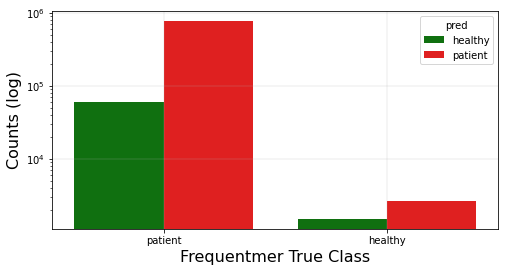

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.countplot(data=frequentmers_predictions, 
              x="frequentmer_class", 
              palette=["green", "red"], 
              hue="pred")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("Frequentmer True Class")
ax.set_ylabel("Counts (log)")
ax.set_yscale("log")
ax.grid(lw=0.4, alpha=0.6)
fig.savefig("counts_recurrency_20.png");

We observe that most of the patient frequentmers are indeed classified as patient, i.e. tend to be found in patient samples. The healthy frequentmers tend to be more mixed on average. This is to be expected, since a part of the control genome is superset of the patient group.

Let's calculate the confusion matrix.

In [37]:
true_positives = frequentmers_predictions[(frequentmers_predictions["frequentmer_class"] == "patient") \
                                          & (frequentmers_predictions["pred"] == "patient")].shape[0]
true_positives

765447

In [38]:
true_negatives = frequentmers_predictions[(frequentmers_predictions["frequentmer_class"] == "healthy") \
                                          & (frequentmers_predictions["pred"] == "healthy")].shape[0]
true_negatives

1492

In [39]:
false_positives =  frequentmers_predictions[(frequentmers_predictions["frequentmer_class"] == "healthy") \
                                            & (frequentmers_predictions["pred"] == "patient")].shape[0]
false_positives

2648

In [40]:
false_negatives = frequentmers_predictions[(frequentmers_predictions["frequentmer_class"] == "patient") \
                                      & (frequentmers_predictions["pred"] == "healthy")].shape[0]
false_negatives

59579

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = np.array([[true_positives, false_positives],
                             [false_negatives, true_negatives]
                            ])
ConfusionMatrixDisplay(confusion_matrix)
plt.show()

In [45]:
import math

def override(x) -> float:
    try:
        return math.log(x)
    except:
        return 0.0 # -float("inf")

We observe that 

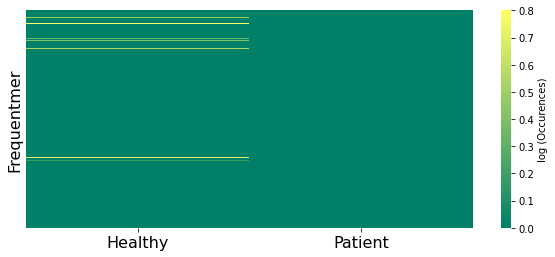

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
temp = grouped_frequentmers[grouped_frequentmers["frequentmer_class"] == "healthy"]
temp.loc[:, "patient_counts"] = temp["patient_counts"].apply(override)
temp.loc[:, "healthy_counts"] = temp["healthy_counts"].apply(override)
sns.heatmap(data=temp[["healthy_counts", "patient_counts"]], 
            cmap="summer", 
            vmax=0.8, 
            vmin=0,
            cbar_kws={'label': 'log (Occurences)'})
ax.set_yticks([])
ax.set_xticks([0.5, 1.5], ["Healthy", "Patient"])
ax.tick_params(axis="both", labelsize=16)
ax.yaxis.label.set_size(16)
ax.set_ylabel("Frequentmer")
plt.gcf().savefig("healthy_heatmap_counts_recurrency_20.png");

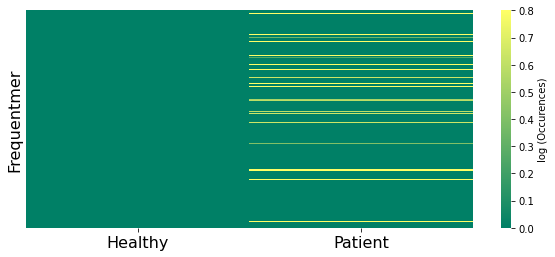

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
temp = grouped_frequentmers[grouped_frequentmers["frequentmer_class"] == "patient"]
temp.loc[:, "patient_counts"] = temp["patient_counts"].apply(override)
temp.loc[:, "healthy_counts"] = temp["healthy_counts"].apply(override)
sns.heatmap(data=temp[["healthy_counts", "patient_counts"]], 
            cmap="summer", 
            vmax=0.8, 
            vmin=0,
            cbar_kws={'label': 'log (Occurences)'})
ax.set_yticks([])
ax.set_xticks([0.5, 1.5], ["Healthy", "Patient"])
ax.tick_params(axis="both", labelsize=16)
ax.yaxis.label.set_size(16)
ax.set_ylabel("Frequentmer")
plt.gcf().savefig("patient_heatmap_counts_recurrency_20.png");

<Axes: xlabel='healthy_counts', ylabel='patient_counts'>

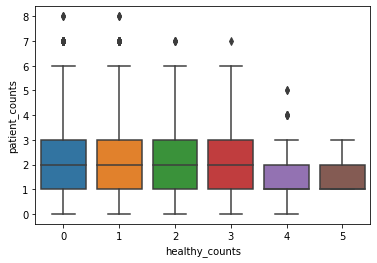

In [79]:
sns.boxplot(data=frequentmers_class[frequentmers_class["fold_id"]==1][["healthy_counts", "patient_counts"]],
           x="healthy_counts", 
           y="patient_counts")

In [55]:
frequentmers_class.loc[:, "total_counts"] = frequentmers_class["patient_counts"] + frequentmers_class["healthy_counts"]
frequentmers_class.head(2)

,frequentmer,length,fold_id,patient_counts,healthy_counts,frequentmer_class,total_counts
0,TGTTGGCCTGTATTAA,23,0,1,0,patient,1
1,CTGCACAGTTGTCACC,20,0,1,0,patient,1


On the next two graphs, we determine how many files were associated with each patient and control frequentmer on the test set.

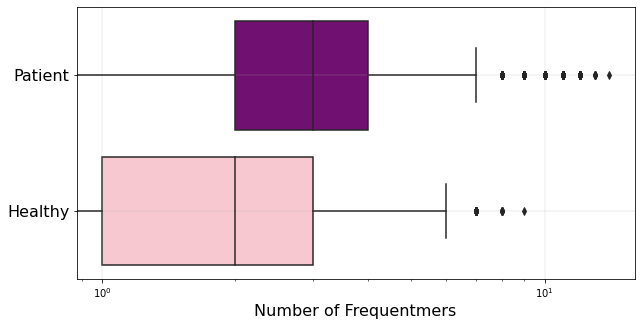

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(data=frequentmers_class, 
            palette=["purple", "pink"], 
            x="total_counts", 
            y="frequentmer_class")
ax.grid(lw=0.4, alpha=0.6)
ax.set_xscale("log")
ax.set_ylabel("")
ax.set_xlabel("Number of Frequentmers")
ax.set_yticks(range(2), ["Patient", "Healthy"])
ax.tick_params(axis="y", labelsize=16)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
fig.savefig(f"testmers_counts_reccurency_{recurrency}.png");

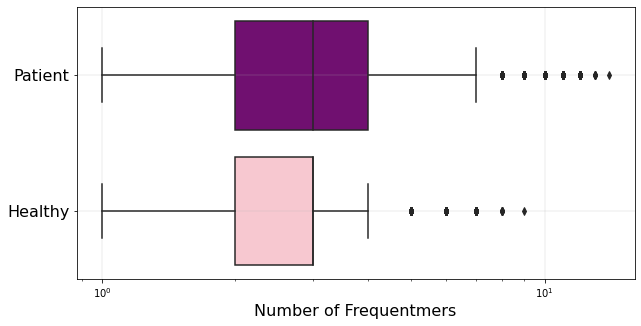

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(data=frequentmers_class[frequentmers_class["total_counts"]>0], 
            palette=["purple", "pink"], 
            x="total_counts", 
            y="frequentmer_class")
ax.grid(lw=0.4, alpha=0.6)
ax.set_xscale("log")
ax.set_ylabel("")
ax.set_xlabel("Number of Frequentmers")
ax.set_yticks(range(2), ["Patient", "Healthy"])
ax.tick_params(axis="y", labelsize=16)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
fig.savefig(f"frequentmers_total_counts_per_sample_reccurency_{recurrency}.png");

### Predictive Analytics

#### ROC Curve

After conducting the exploratory data analysis we continue with the predictive analytics. The first step is to plot a cross validated ROC curve for logistic regression across all the ten folds.

In [114]:
from sklearn.metrics import roc_curve

In [115]:
def cross_val_roc(model, X_train_dict, X_test_dict, y_train_dict, y_test_dict) -> Dict[str, np.ndarray]:
    """"KFold validation"""
    scores = defaultdict(list)
    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    roc_df = pd.DataFrame(columns=["true", "proba"])
    
    for fold_id in X_train_dict:
        X_train = X_train_dict[fold_id]
        X_test = X_test_dict[fold_id]
        y_train = y_train_dict[fold_id]
        y_test = y_test_dict[fold_id]
        
        model.fit(X_train, y_train)

        # score model
        scores["accuracy"].append(model.score(X_test, y_test))

        
        y_proba_expensive = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba_expensive)

        fpr, tpr, _ = roc_curve(y_test, y_proba_expensive)

        scores["auc_score"].append(auc_score)

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(scores["auc_score"][-1])
        
        
        y_pred = model.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        scores["precision"].append(precision)
        scores["recall"].append(recall)
        scores["f1"].append(f1)
        
      
        temp = pd.DataFrame(np.stack([y_test, y_proba_expensive])).T
        temp.columns = ["true", "proba"]
        
        roc_df = pd.concat([roc_df.reset_index(drop=True), temp], axis=0).reset_index(drop=True)
    
    # cast lists to numpy arrays
    for key in scores.copy():
        scores[key] = np.array(scores[key])
        
    return dict(scores), roc_df, tprs, aucs

In [116]:
model = LogisticRegression(max_iter=2000, C=0.01, penalty="l2")

scores, roc_df, tprs, aucs = cross_val_roc(model, X_train_dict, X_test_dict, y_train_dict, y_test_dict)

In [124]:
scores["auc_score"].mean()

0.9132069319569318

In [125]:
from sklearn.metrics import auc

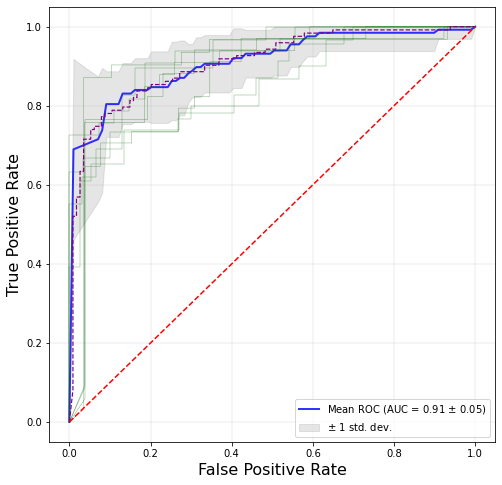

In [126]:
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
base_fpr = np.linspace(0, 1, 101)
mean_fpr = np.linspace(0, 1, 100)

# plt.figure(figsize=(8, 8))
# plt.axes().set_aspect('equal', 'datalim')


fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.plot(
     mean_fpr,
     mean_tpr,
     color="b",
     label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
     lw=2,
     alpha=0.8,
 )

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
for _ in range(8):
    sample = roc_df.sample(60, replace=False)
    y_true = sample["true"]
    y_proba_expensive = sample["proba"]
    fpr_roc, tpr_roc, _ = roc_curve(y_true, y_proba_expensive)
    ax.plot(fpr_roc, tpr_roc, color="darkgreen", lw=0.4, alpha=0.6)

y_true = roc_df["true"]
y_proba_expensive = roc_df["proba"]
fpr_roc, tpr_roc, _ = roc_curve(y_true, y_proba_expensive)

ax.plot(fpr_roc, tpr_roc, color="purple", lw=1.2, linestyle='--', alpha=1.0)

ax.fill_between(
 mean_fpr,
 tprs_lower,
 tprs_upper,
 color="grey",
 alpha=0.2,
 label=r"$\pm$ 1 std. dev.",
)

ax.set(
 xlim=[-0.05, 1.05],
 ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
 # title="Receiver operating characteristic example",
)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# ax.title.set_size(20)
ax.plot(base_fpr, base_fpr, color='red', linestyle='--')
ax.legend(loc="lower right")
ax.grid(lw=0.4, alpha=0.6)
plt.show()
fig.savefig(f"logreg_roc_recurrency_{recurrency}.png")

#### XGBClassifier ROC Curve

In [127]:
xgb = XGBClassifier(**{'max_depth': 11, 
                       'gamma': 0.3, 
                       'eta': 0.2, 
                       'alpha': 6}
)

In [128]:
cv_results, roc_df, tprs, aucs = cross_val_roc(xgb, X_train_dict, X_test_dict, y_train_dict, y_test_dict)
cv_results["auc_score"].mean()

0.9071835109335108

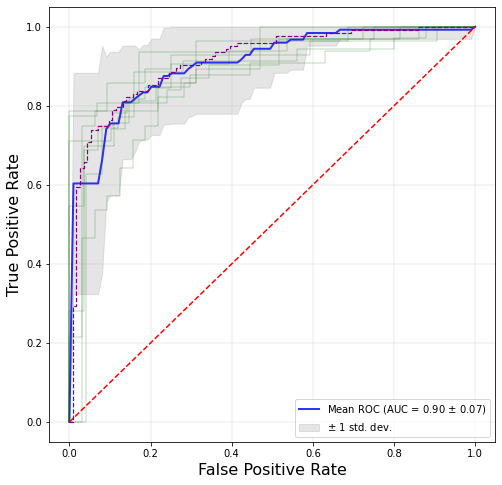

In [129]:
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
base_fpr = np.linspace(0, 1, 101)
mean_fpr = np.linspace(0, 1, 100)

# plt.figure(figsize=(8, 8))
# plt.axes().set_aspect('equal', 'datalim')


fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.plot(
     mean_fpr,
     mean_tpr,
     color="b",
     label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
     lw=2,
     alpha=0.8,
 )

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
for _ in range(8):
    sample = roc_df.sample(60, replace=False)
    y_true = sample["true"]
    y_proba_expensive = sample["proba"]
    fpr_roc, tpr_roc, _ = roc_curve(y_true, y_proba_expensive)
    ax.plot(fpr_roc, tpr_roc, color="darkgreen", lw=0.4, alpha=0.6)

y_true = roc_df["true"]
y_proba_expensive = roc_df["proba"]
fpr_roc, tpr_roc, _ = roc_curve(y_true, y_proba_expensive)

ax.plot(fpr_roc, tpr_roc, color="purple", lw=1.2, linestyle='--', alpha=1.0)

ax.fill_between(
 mean_fpr,
 tprs_lower,
 tprs_upper,
 color="grey",
 alpha=0.2,
 label=r"$\pm$ 1 std. dev.",
)

ax.set(
 xlim=[-0.05, 1.05],
 ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
 # title="Receiver operating characteristic example",
)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# ax.title.set_size(20)
ax.plot(base_fpr, base_fpr, color='red', linestyle='--')
ax.legend(loc="lower right")
ax.grid(lw=0.4, alpha=0.6)
plt.show()
fig.savefig(f"xgb_roc_recurrency_{recurrency}.png")

#### Coefficience Importance

In [131]:
def load_train_test_split(fold_id: int, recurrency: int = 15) -> Tuple[pd.DataFrame, ...]:
    train_columns, train_df = load_train_data(fold_id, recurrency=recurrency)
    test_df = load_test_data(fold_id, train_columns, recurrency=recurrency)
    X_train, y_train = get_X_y(train_df)
    X_test, y_test = get_X_y(test_df)
    return X_train, X_test, y_train, y_test

In [132]:
def cross_val_score(model, cv: int = 10, recurrency: int = 15) -> Dict[str, np.ndarray]:
    """"KFold validation"""
    scores = defaultdict(list)
    
    all_coefs = pd.DataFrame([], columns=["frequentmer", "importance", "fold_id", "label"])
    for fold_id in tqdm(range(cv)):
        X_train, X_test, y_train, y_test = load_train_test_split(fold_id=fold_id, 
                                                                 recurrency=recurrency)
        
        train_fold = pickle.load(open(full_path + f'frequentmers_fold_{fold_id}_recurrency_{recurrency}.json', "rb"))
        
        column_labels = defaultdict(list)
        for key, val in train_fold.items():
            if val[0].startswith("H"):
                label = 0
            else:
                label = 1
                
            column_labels["frequentmer"].append(key)
            column_labels["label"].append(label)
            
        column_labels = pd.DataFrame(column_labels)

        model.fit(X_train, y_train)
        
        coefs_df = pd.DataFrame(model.coef_, 
                                columns=X_train.columns).T
        coefs_df.reset_index(inplace=True)
        coefs_df.columns = ["frequentmer", "importance"]
        coefs_df.loc[:, "fold_id"] = fold_id
        
        merged_df = coefs_df.merge(column_labels, on="frequentmer", how="inner")
            
        all_coefs = pd.concat([all_coefs, merged_df], axis=0).reset_index(drop=True)
        
        # score model
        scores["accuracy"].append(model.score(X_test, y_test))
        
        y_pred = model.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        scores["precision"].append(precision)
        scores["recall"].append(recall)
        scores["f1"].append(f1)
    
    # cast lists to numpy arrays
    for key in scores.copy():
        scores[key] = np.array(scores[key])
        
    return dict(scores), all_coefs

In [133]:
model = LogisticRegression(C=0.01, max_iter=3000)

cv_results, all_coefs = cross_val_score(model, cv=10, recurrency=20)
cv_results

100%|██████████| 10/10 [03:39<00:00, 21.98s/it]


{'accuracy': array([0.95833333, 0.83333333, 0.79166667, 0.83333333, 0.83333333,
        0.83333333, 0.75      , 0.82608696, 0.86956522, 0.7826087 ]),
 'precision': array([1.        , 0.73333333, 0.84615385, 0.9       , 0.88888889,
        0.84615385, 0.73333333, 0.85714286, 0.92857143, 0.75      ]),
 'recall': array([0.92857143, 1.        , 0.78571429, 0.75      , 0.72727273,
        0.84615385, 0.84615385, 0.66666667, 0.86666667, 0.81818182]),
 'f1': array([0.96296296, 0.84615385, 0.81481481, 0.81818182, 0.8       ,
        0.84615385, 0.78571429, 0.75      , 0.89655172, 0.7826087 ])}

In [134]:
all_coefs.head()

,frequentmer,importance,fold_id,label
0,TGTTGGCCTGTATTAA,0.000284,0,1
1,CTGCACAGTTGTCACC,0.000852,0,1
2,AACTTGTGCCATTCTG,0.004109,0,1
3,TAGCATGAATTCCGCA,0.001777,0,1
4,GTGGTACGCCGACTGA,0.000281,0,1


In [135]:
all_coefs.sort_values(by=["importance"], ascending=False, inplace=True)
all_coefs.reset_index(drop=True, inplace=True)
all_coefs

,frequentmer,importance,fold_id,label
0,GAGGGCCAATTAGTGC,0.010960,0,1
1,AGAGGGCCAATTAGTG,0.010960,0,1
2,AGAGGGCCAATTAGTG,0.010128,4,1
3,GAGGGCCAATTAGTGC,0.010128,4,1
4,ACTCAACAACTATCGC,0.010109,0,1
...,...,...,...,...
1827050,GGGCTCGCGAGATCCA,-0.006194,1,0
1827051,AGTTGTATAAGTAGTC,-0.006275,8,0
1827052,AGAGATCTGATCCACG,-0.006334,0,0
1827053,CCGCTTACGTACGTCC,-0.006521,0,0


In [136]:
grouped = all_coefs.groupby("frequentmer").agg({"importance": lambda x: x.sum()/10.0,
                                               "label": "first"})

In [137]:
grouped.head(2)

,importance,label
frequentmer,,
AAAAAAACACACTAGT,0.000313,1
AAAAAAACCTAGCGAT,0.000493,1


In [138]:
grouped["importance"].isna().sum()

0

In [139]:
grouped.loc[:, "abs_importance"] = grouped["importance"].apply(lambda x: abs(x))
grouped.head()

,importance,label,abs_importance
frequentmer,,,
AAAAAAACACACTAGT,0.000313,1,0.000313
AAAAAAACCTAGCGAT,0.000493,1,0.000493
AAAAAAACTAAGTGTG,0.000273,1,0.000273
AAAAAACACGTAGCTC,0.000066,1,0.000066
AAAAAACCACCTAGGT,0.000094,1,0.000094


In [140]:
grouped.label.value_counts()

label
1    852704
0      4304
Name: count, dtype: int64

In [141]:
grouped.sort_values(by=["abs_importance"], ascending=False, inplace=True)

value_counts = defaultdict(list)

for ceiling in tqdm(range(100, 500000, 100)):
    values = grouped.head(ceiling)["label"].value_counts().to_dict()
    value_counts["ceiling"].append(ceiling)
    value_counts["healthy"].append(values[0] if 0 in values else 0)
    value_counts["patient"].append(values[1])

value_counts = pd.DataFrame(value_counts)
value_counts = value_counts.set_index("ceiling")
value_counts.loc[:, "ratio"] = value_counts["patient"]/(value_counts["healthy"] + value_counts["patient"])
value_counts.head()

100%|██████████| 4999/4999 [00:31<00:00, 160.14it/s]


,healthy,patient,ratio
ceiling,,,
100,3,97,0.970000
200,11,189,0.945000
300,16,284,0.946667
400,27,373,0.932500
500,41,459,0.918000


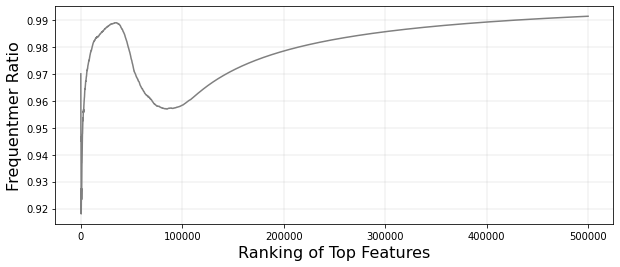

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
value_counts[["ratio"]].plot(color="gray", ax=ax)
ax.legend(handles=[], frameon=False)
ax.grid(lw=0.4, alpha=0.6)
ax.set_xlabel("Ranking of Top Features")
ax.set_ylabel("Frequentmer Ratio")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
fig.savefig(f"patient_vs_total_ratio_importance_recurrency_{recurrency}.png")

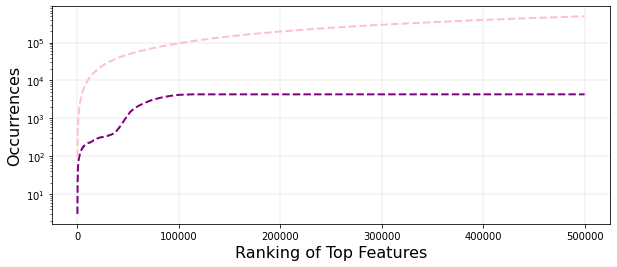

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
value_counts[["healthy", "patient"]].plot( 
                                                               ax=ax, 
                                                               lw=2.0,
                                                               linestyle='--',
                                                               color=["purple", "pink"])
ax.grid(lw=0.4, alpha=0.6)
ax.set_yscale("log")
ax.xaxis.label.set_size(16)
ax.set_xlabel("Ranking of Top Features")
ax.set_ylabel("Occurrences")
ax.yaxis.label.set_size(16)
# ax.set_xticks([])
ax.legend(handles=[], frameon=False)
fig.savefig(f"healthy_patient_frequentmers_breakdown_sorted_importance_recurrency_{recurrency}.png");

In [118]:
feature_importance_score = defaultdict(list)

model = LogisticRegression(C=0.01, max_iter=2000, penalty="l2")
cv = 10
for fold_id in tqdm(range(cv)):
        model.fit(X_train_dict[fold_id], y_train_dict[fold_id])
        
        coefficients = pd.DataFrame(model.coef_, columns=X_train_dict_columns[fold_id]).T.reset_index()
        coefficients.columns = ["frequentmer", "importance"]
        coefficients.loc[:, "abs_importance"] = coefficients["importance"].apply(abs)
        coefficients.sort_values(by=["abs_importance"], ascending=False, inplace=True)
        coefficients.reset_index(drop=True, inplace=True)
        
        for sample_size in range(10, 1010, 10):
            coefficients_chunk = coefficients.head(sample_size)["frequentmer"].tolist()
            
            model = LogisticRegression(C=0.01, max_iter=2000, penalty="l2")
            model.fit(X_train_dict[fold_id][coefficients_chunk], y_train_dict[fold_id])
            
            y_pred_proba_patient = model.predict_proba(X_test_dict[fold_id][coefficients_chunk])[:, 1]
            auc_roc = roc_auc_score(y_test_dict[fold_id], y_pred_proba_patient)
            
            feature_importance_score["fold_id"].append(fold_id)
            feature_importance_score["auc_score"].append(auc_roc)
            feature_importance_score["sample_size"].append(sample_size)
            
            
            
feature_importance_score_df = pd.DataFrame(feature_importance_score)
feature_importance_score_df.head()

100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


,fold_id,auc_score,sample_size
0,0,0.732143,10
1,0,0.921429,20
2,0,0.950000,30
3,0,0.914286,40
4,0,0.907143,50


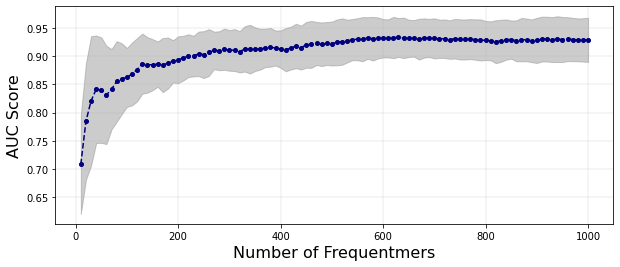

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
grouped_importance_per_sample_size = feature_importance_score_df.groupby("sample_size").agg(auc_score_mean=("auc_score", "mean"), 
                                                        auc_score_std_upper=("auc_score", lambda x: x.mean() - x.std()),
                                                          auc_score_std_lower=("auc_score", lambda x: x.mean() + x.std())
                                                      )
                            
xs = grouped_importance_per_sample_size.index.tolist()
ax = plt.gca()
grouped_importance_per_sample_size["auc_score_mean"].plot(
             linestyle='--', 
             lw=1.5, 
             color="navy", 
             marker='o',
            markersize=4,
             ax=ax)
ax.fill_between(xs, grouped_importance_per_sample_size["auc_score_std_lower"],
                   grouped_importance_per_sample_size["auc_score_std_upper"],
                color='gray',
                alpha=0.4,
               )
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("Number of Frequentmers")
ax.set_ylabel("AUC Score")
ax.grid(lw=0.4 , alpha=0.6)
fig.savefig(f"top_features_auc_logistic_recurrency_{recurrency}.png");

### PCA

### HBV & Alcohol Frequentmers

#### Alcohol Patients

In [12]:
sample_df = pd.read_excel("nature13568-s1/Table 1.xlsx").iloc[:, 1:9]\
                .rename(columns={"Alcohol related (Y or N)": "alcohol",
                                "Cirrhotic(Y or N)": "Cirrhotic",
                                "HBV related  (Y or N)": "HBV"
                        })
sample_df.head()

,Sample ID,Country,Gender,Age,BMI (kg/m2),Cirrhotic,HBV,alcohol
0,HD-1,China,female,40,20.028842,N,N,N
1,HD-2,China,female,46,20.829995,N,N,N
2,HD-3,China,male,45,19.579672,N,N,N
3,HD-4,China,male,38,20.047446,N,N,N
4,HD-5,China,female,43,22.375680,N,N,N


In [13]:
samples_with_positive_alcohol = sample_df[sample_df["alcohol"] == "Y"]["Sample ID"].tolist()
len(samples_with_positive_alcohol)

34

In [14]:
all_samples = set(sample_df["Sample ID"].tolist())
without_alcohol = all_samples - set(samples_with_positive_alcohol)
len(without_alcohol)

203

In [15]:
alcoholic_frequentmers = defaultdict(set)
total_alcohol_frequentmers = 0
total_mixed = 0
for fold_id in tqdm(range(10)):
    with frequentmers_path.joinpath(f"frequentmers_fold_{fold_id}_recurrency_15.json").open("rb") as f:
        frequentmers = pickle.load(f)
        
    for frequentmer, list_of_samples in frequentmers.items():
        if any(sample.split(".")[0] in samples_with_positive_alcohol for sample in list_of_samples):
            total_alcohol_frequentmers += 1
            if any(sample.split(".")[0] in without_alcohol for sample in list_of_samples):
                total_mixed += 1
            
        if all(sample.split(".")[0] in samples_with_positive_alcohol for sample in list_of_samples):
            alcoholic_frequentmers[frequentmer] = alcoholic_frequentmers[frequentmer].union(list_of_samples)

100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


In [16]:
lengths = list(map(len, frequentmers.values()))

In [17]:
min(lengths), max(lengths)

(15, 59)

In [18]:
total_alcohol_frequentmers, total_mixed

(5524050, 5524050)

In [19]:
total_alcohol_frequentmers - total_mixed

0

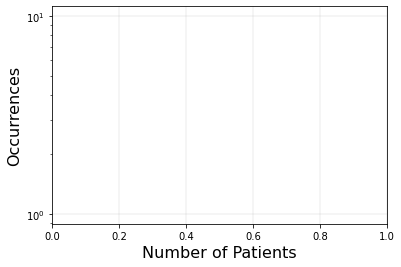

In [20]:
lengths = list(map(len, alcoholic_frequentmers.values()))
sns.histplot(lengths, bins=4, color="darkcyan")
ax = plt.gca()
ax.grid(lw=0.4, alpha=0.6)
ax.set_xlabel("Number of Patients")
ax.set_ylabel("Occurrences")
# ax.set_xticks(range(1, 1+len(counts)), ["" if idx%3 else round(tick, 1) for idx, tick in enumerate(counts.keys())])
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_yscale("log")
plt.gcf().savefig(f"drunklog_frequentmers_recurrency_{recurrency}_remake.png")

#### HBV patients

In [91]:
samples_with_positive_HBV = sample_df[sample_df["HBV"] == "Y"]["Sample ID"].tolist()
len(samples_with_positive_HBV)

99

In [99]:
hbv_frequentmers = defaultdict(set)

recurrency = 15
for fold_id in tqdm(range(10)):
    with frequentmers_path.joinpath(f"frequentmers_fold_{fold_id}_recurrency_{recurrency}.json").open("rb") as f:
        frequentmers = pickle.load(f)
        
    for frequentmer, list_of_samples in frequentmers.items():
        if all(sample.split(".")[0] in samples_with_positive_HBV for sample in list_of_samples):
            hbv_frequentmers[frequentmer] = hbv_frequentmers[frequentmer].union(set(list_of_samples))

100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


In [100]:
len(hbv_frequentmers)

55780

Performing some sanity checks...

In [101]:
assert set(samples_with_positive_HBV) == {file.split(".")[0] for collection in hbv_frequentmers.values() for file in collection}

In [102]:
for hbv_files in hbv_frequentmers.values():
    for file in hbv_files:
        if file.split(".")[0] not in samples_with_positive_HBV:
            print(file)

In [103]:
len({sample.split(".")[0] for samples_found in hbv_frequentmers.values() for sample in samples_found})

99

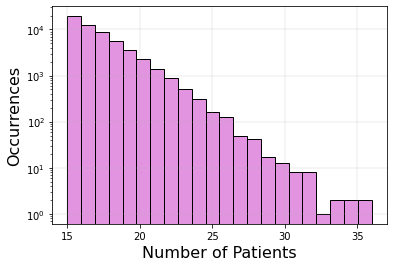

In [104]:
lengths = list(map(len, hbv_frequentmers.values()))
# counts = {count/99.0: lengths.count(count) for count in set(lengths)}
sns.histplot(lengths, bins=22, color="orchid")
ax = plt.gca()
ax.grid(lw=0.4, alpha=0.6)
ax.set_xlabel("Number of Patients")
ax.set_ylabel("Occurrences")
# ax.set_xticks(range(1, 1+len(counts)), ["" if idx%3 else round(tick, 1) for idx, tick in enumerate(counts.keys())])
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_yscale("log")
plt.gcf().savefig(f"drunklog_frequentmers_hbv_recurrency_{recurrency}_remake.png")

In [108]:
lengths = list(map(len, hbv_frequentmers.values()))
counts = {count/99.0: lengths.count(count) for count in set(lengths)}

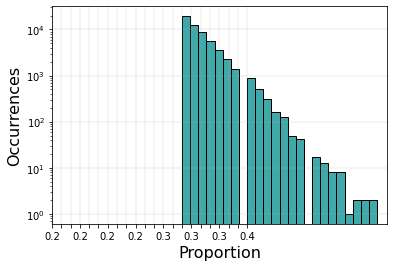

In [110]:
sns.histplot(lengths, bins=24, color="darkcyan")
ax = plt.gca()
ax.grid(lw=0.4, alpha=0.6)
ax.set_xlabel("Proportion")
ax.set_ylabel("Occurrences")
ax.set_xticks(range(1, 1+len(counts)), ["" if idx%3 else round(tick, 1) for idx, tick in enumerate(counts.keys())])
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_yscale("log")
plt.gcf().savefig(f"drunklog_frequentmers_recurrency_{recurrency}.png")

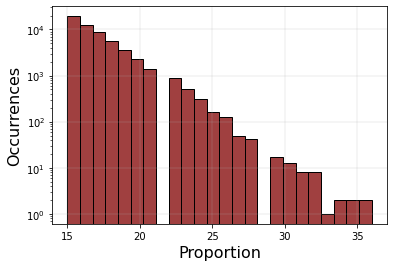

In [111]:
lengths = list(map(len, hbv_frequentmers.values()))
sns.histplot(lengths, bins=24, color="maroon")
ax = plt.gca()
ax.grid(lw=0.4, alpha=0.6)
ax.set_xlabel("Proportion")
ax.set_ylabel("Occurrences")
# ax.set_xticks(range(1, 1+len(counts)), ["" if idx%3 else round(tick, 1) for idx, tick in enumerate(counts.keys())])
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_yscale("log")
plt.gcf().savefig(f"drunklog_frequentmers_hbv_recurrency_{recurrency}.png")

### APPENDIX

The script below creates the legend.

In [ ]:
colors = ["purple", "pink"]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(2)]
labels = ["Healthy", "Patient"]
legend = plt.legend(handles, labels, loc=3, framealpha=1,  markerscale=2.0, prop={'size':15}, frameon=True)

def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=1000, bbox_inches=bbox)


export_legend(legend)
plt.axis("off")
plt.gcf().savefig("legend_patient_healthy.png");